### Lecture 4, Chord detection using chroma features

Notebook prepared by [Vsevolod Eremenko](https://github.com/seffka) demonstrating chord detection task using chroma features. The notebook is accompanied with sound and annotation files in the folder: "data/chroma"

In [1]:
import os
import sys
import pickle
import numpy as np
import essentia.standard as ess
import essentia.streaming as esstr
import essentia

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

%matplotlib inline
import IPython.display as ipd
from pygments import highlight
from pygments.lexers import JavascriptLexer
from pygments.formatters import HtmlFormatter
import IPython
import pandas as pd
import seaborn as sns

from sklearn.mixture import GaussianMixture
import mir_eval.sonify as sonify


### Function definitions to calculate chroma and display it along with chord annotations

In [2]:
pitchClasses = ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab']
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']

pitches = {'A':0, 'B':2, 'C':3, 'D':5, 'E':7, 'F':8, 'G':10}
alt={'b':-1, '#':1}

def tuning(filename):
    """
    Detect tuning frequency with Essentia
    """
    chromaHopSize = 2048
    frameSize = 8192
    loader = esstr.MonoLoader(filename=filename)
    framecutter = esstr.FrameCutter(hopSize=chromaHopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = esstr.TuningFrequency()
    pool = essentia.Pool()
 
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')

    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class AnnotatedSegments:
    """
    Container for segment labels
    """
    def __init__(self, labels, startTimes, durations):
        self.labels = labels
        self.startTimes = startTimes
        self.durations = durations
        
def loadAnnotatedSegmentsFromLab(filename):
    '''
    Loads/reads segments annotations from .lab file and returns an AnnotatedSegments object
    '''
    labels = []
    startTimes = []
    durations = []
    with open(filename) as f:
        for line in f:
            start, end, label = line.strip().split("\t")
            labels.append(label)
            startTimes.append(float(start))
            durations.append(float(end) - float(start))
    return AnnotatedSegments(
        np.array(labels, dtype='object'),
        np.array(startTimes, dtype='float'),
        np.array(durations, dtype='float'))

def plotSegments(ax, annotatedSegments, timeScale, hopSize, fs = 44100, startY = 0, height = 0.1, title=''):
    '''
    Plot segments annotations on given axes object
    '''
    patches = []
    color1='#FFFFFF'
    color2='#AAAAAA'
    color = color1
    for i in range(len(annotatedSegments.labels)):
        s = annotatedSegments.startTimes[i]
        d = annotatedSegments.durations[i]
        l = annotatedSegments.labels[i]
        if (color == color1):
            color = color2
        else:
            color = color1
        polygon = Polygon([
            [s, startY],
            [s, startY + height],
            [s + d, startY + height],
            [s + d, startY]], closed=True, fill=True, color=color)
        ax.add_patch(polygon)
        # to fight strange scaling issue
        if (i < len(annotatedSegments.labels) - 1):
            ax.text(s + d/2.0, height / 2.0, annotatedSegments.labels[i], ha='center', va='center')
        else:
            ax.text(s, height / 2.0, annotatedSegments.labels[i], va='center')
    ax.axis([timeScale[0], timeScale[-1], 0, height])
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        top='off',      # ticks along the bottom edge are off
        bottom='on',         # ticks along the top edge are off
        labelbottom='on') # labels along the bottom edge are off
    ax.set_xlabel('time(seconds)')
    ax.margins(y=0)
    ax.set_title(title)
           
def previewJSONFile(jsonFile):
    """
    Returns HTML with fine preview of given file
    """
    with open(jsonFile) as f:
        code = f.read()
    formatter = HtmlFormatter()
    return '<style type="text/css">{}</style>{}'.format(
        formatter.get_style_defs('.highlight'),
        highlight(code, JavascriptLexer(), formatter))

def subFeatures(featureData, startTime, endTime, fs):
    """
    Extract portion of the feature array (e.g. spectra or chroma) from startTime to endTime
    """
    if (startTime == None and endTime == None):
        return featureData
    else:
        s = 0
        e = len(featureData)
        if (startTime != None):
            s = max(0.0, int(float(startTime) * fs))
        if (endTime != None):
            e = min(int(float(endTime) * fs) + 1, e)
        return featureData[s:e]
        
def subSegments(segments, startTime, endTime):
    """
    Extract portion of annotation segments
    """
    if (startTime == None and endTime == None):
        return segments
    if (startTime == None):
        startTime = segments.startTimes[0]
    s = np.searchsorted(segments.startTimes, startTime)
    if (s >= len(segments.startTimes) or segments.startTimes[s] > startTime):
        s -= 1
    s = max(0, s)
    if (endTime == None):
        endTime = segments.startTimes[-1] + segments.durations[-1]
    e = np.searchsorted(segments.startTimes, endTime) - 1
    e = min(e + 1, len(segments.startTimes))
    result = AnnotatedSegments(
        segments.labels[s:e], np.copy(segments.startTimes[s:e]), np.copy(segments.durations[s:e]))
    result.durations[0] -= (startTime - result.startTimes[0])
    result.startTimes[0] = startTime
    result.durations[-1] = min(result.durations[-1], endTime - result.startTimes[-1])
    return result

def plotWave(ax, wave, timeScale,label=''):
    """
    Plot wave with given timescale
    """
    ax.plot(timeScale, wave)
    ax.set_ylabel('amplitude')
    ax.set_xlabel('time (seconds)')
    ax.set_title('Waveform - '+label)
    ax.axis([timeScale[0], timeScale[-1], min(wave), max(wave)])
    
def plotSpectra(ax, spectra, timeScale,label='',hopSize = 4096, fs = 44100, frameSize = 16384):
    """
    Plot given spectra up to 2000 Hz
    """
    MAX_FREQ=2000
    freqAx_normalized=np.arange(spectra.shape[1])/float(frameSize)
    freqAxHz=float(fs)*freqAx_normalized
    timeAxSec=np.arange(spectra.shape[0])*hopSize/float(fs) + timeScale[0]
    ax.pcolormesh(timeAxSec, freqAxHz, spectra.transpose())
    ax.axis([timeScale[0], timeScale[-1], 0 , MAX_FREQ])
    ax.set_title('Log Magnitude Spectrum - '+label)
    ax.set_ylabel('frequency(Hz)')
    ax.set_xlabel('time(seconds)')

def plotChroma(ax, chroma,label=''):
    """
    Plot chroma
    """
    heatmap = ax.pcolor(chroma.transpose())
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        top='off',      # ticks along the bottom edge are off
        bottom='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    ax.set_title('Chromagram - '+label)
    ax.set_yticks(np.arange(chroma.shape[1]) + 0.5, minor=False)
    ax.set_yticklabels(pitchClasses)
    ax.set_ylabel('Pitch class')
    
def plotAnnotatedChroma(wave, chroma, spectra, segments, label='',hopSize=4096, fs = 44100, frameSize = 16384, startTime = None, endTime = None):
    """
    Plots waveform, spectra, chromagarem and annotation for given data.
    Returns wave cuted to [startTime; endTime].
    """
    wave = subFeatures(wave, startTime, endTime, fs)
    chroma = subFeatures(chroma, startTime, endTime, float(fs)/hopSize)
    spectra = subFeatures(spectra, startTime, endTime, float(fs)/hopSize)
    segments = subSegments(segments, startTime, endTime)
    if (startTime == None):
        startTime = 0.0
    t=np.arange(wave.size)/float(fs) + startTime
    fig = plt.figure(figsize=(20, 12), dpi=80)

    gs = matplotlib.gridspec.GridSpec(4, 1,
                           width_ratios=[1],
                           height_ratios=[6,6,6,1])
    plotWave(plt.subplot(gs[0]), wave, t,label)
    plotSpectra(plt.subplot(gs[1]), spectra, t, label,hopSize = hopSize, fs = fs, frameSize = frameSize)
    plotChroma(plt.subplot(gs[2]), chroma,label)
    alabels = plt.subplot(gs[3])
    plotSegments(alabels, segments, t, hopSize = hopSize, title='Annotation - '+label)
    plt.subplots_adjust(hspace = .001)
    plt.tight_layout()
    plt.show()
    return wave
    
def rootPitch(label):
    partsAndBass = label.split('/')
    parts = partsAndBass[0].split(':')
    note = parts[0]
    if (note[0] == 'N'):
        return 0
    pitch=pitches[note[0]]
    if (len(note) >= 2):
        for i in range(1, len(note)):
            pitch = pitch + alt[note[i]]
    return pitch

def annotateEachChromaSample(chroma, segments, hopSize = 4096, fs = 44100):
    """
    Assign chord label to each chroma vector
    """
    labels = np.empty((len(chroma)), dtype=('object'))
    s = 0
    for i in range(len(chroma)):
        timestamp = i * float(hopSize) / fs
        if (s >= len(segments.startTimes)) :
            labels[i] = 'N'
        elif (timestamp <= segments.startTimes[s] + segments.durations[s]):
            labels[i] = segments.labels[s]
        else:
            s += 1
            if (s < len(segments.startTimes) and
                timestamp >= segments.startTimes[s] and
                timestamp <= segments.startTimes[s] + segments.durations[s]) :
                labels[i] = segments.labels[s]
            else: 
                labels[i] = 'N'
    return labels

def preprocessTransposedChromas(chroma):
    """
    Apply log-ratio transform.
    """
    #disabled for this notebook, you can add a pre-processing step here
    return chroma

def transposeToARoot(labels, src_chroma):
    """
    Transpose chroma vector to 'A' root.
    """
    chroma = np.empty(src_chroma.shape, dtype=('object'))
    for i in range(len(src_chroma)):
        chroma[i] = np.roll(src_chroma[i], shift=12 - rootPitch(labels[i]))
    return preprocessTransposedChromas(chroma)

def chromaViolinPlot(chroma, hopSize=4096, fs=44100):
    """
    Plot chroma distribution histograms
    Violin plot: https://en.wikipedia.org/wiki/Violin_plot
    """
    sns.set(style="white", context="talk")
    dChord = pd.DataFrame(data=chroma, columns=degrees)
    fig, ax = plt.subplots(figsize=(20, 12), dpi=80)
    sns.violinplot(data=dChord, inner="point", ax = ax)
    plt.title('Chroma distribution histograms')
    plt.show()   

### Chroma estimation in essentia.


In [3]:
#Parameter initialization
NRG_CUTOFF_COEFFICIENT = 0.01
SMOOTHING_TIME = 0.2

def zeroLowEnergy(chroma, spectra):
    """
    Set chromas for low energy frames to zero.
    """
    NRG=np.sum(np.power(spectra,2), axis=1)
    chroma[NRG<np.max(NRG)*NRG_CUTOFF_COEFFICIENT] = np.zeros(12)
    return chroma

def smooth(x, window_len=11, window='hanning'):
    """Smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    y = np.zeros(x.shape)
    for i in range(np.size(x,1)):
        if np.size(x, 0) < window_len:
            raise (ValueError, "Input vector needs to be bigger than window size.")
        if window_len < 3:
            return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
            raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        xx = x[:, i]
        s = np.r_[xx[window_len - 1:0:-1], xx, xx[-1:-window_len:-1]]
        # print(len(s))
        if window == 'flat':  # moving average
            w = np.ones(window_len, 'd')
        else:
            w = eval('np.' + window + '(window_len)')
        start = int(window_len / 2)
        end = start + len(xx)
        y[:,i] = np.convolve(w / w.sum(), s, mode='valid')[start:end]
    return y

def smoothChroma(chroma, hopSize = 4096, fs = 44100):
    """
    Smooth chroma features by convolving each of 12 chroma sequences with hanning window.
    """
    return smooth(chroma, window_len=int(SMOOTHING_TIME * fs / hopSize), window='hanning').astype(
                         'float32')

def loadChromaAndSpectrum(filename, frameSize, tuningFreq=440, hopSize = 4096):
    """
    Extract HPCP chroma features with essentia
    """
    loader = esstr.MonoLoader(filename = filename)
    framecutter = esstr.FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = esstr.Windowing(type="blackmanharris62")
    spectrum = esstr.Spectrum()
    spectralpeaks = esstr.SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    hpcp = esstr.HPCP(
        size=12,
        referenceFrequency = tuningFreq,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitSum')
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectrum.spectrum >> (pool, 'spectrum.magnitude')
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    chroma = pool['chroma.hpcp']
    spectra = pool['spectrum.magnitude']
    chroma = zeroLowEnergy(chroma, spectra)
    chroma = smoothChroma(chroma)
    return chroma, spectra

def loadWaveChromaSpectra(filename, frameSize = 16384, hopSize = 4096, fs = 44100):
    """
    Loads and returns waveform, chroma and audio for given file
    """          
    wave = ess.MonoLoader(filename = filename, sampleRate = fs)()
    chroma, spectra = loadChromaAndSpectrum(
        filename = filename, frameSize = frameSize, tuningFreq = 440, hopSize = hopSize)
    #tuning frequency is set as 440, you can use an estimate from the audio file  
    # using the function tuning() at the top of this cell
    return wave, chroma, spectra

In [4]:
#Actual data analysis starts here
soundsDIR='../data/chroma/'
fs = 44100
frameSize = 16384
hopSize = 4096

#Print sample annotation file content
IPython.display.HTML(previewJSONFile(soundsDIR + 'maj35fromE.lab'))

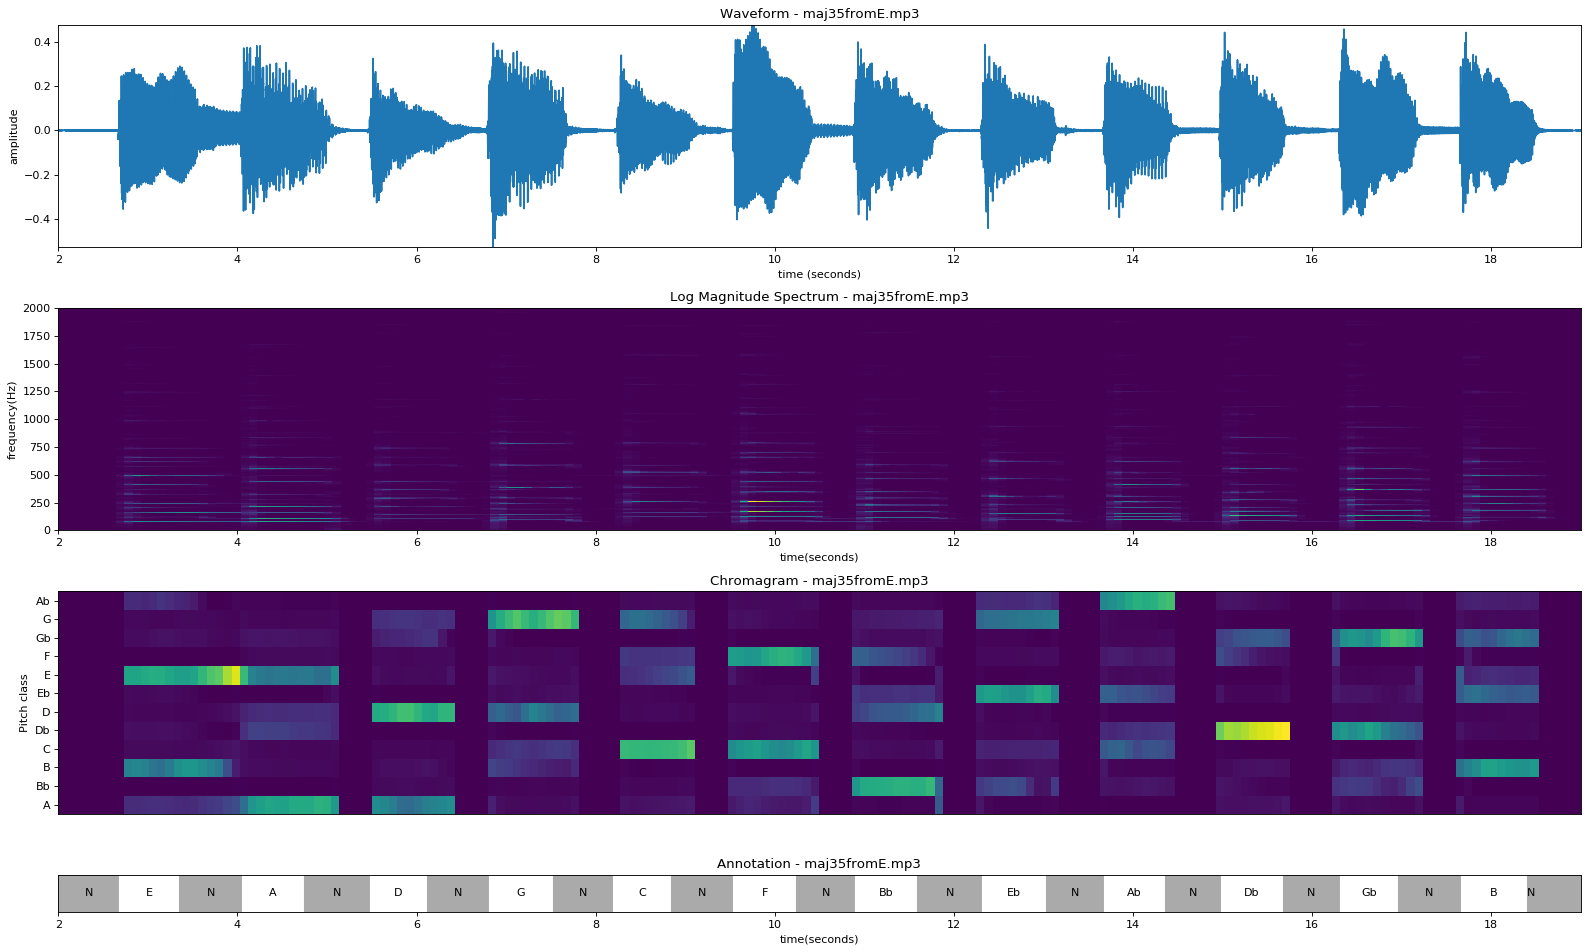

In [5]:
# Plotting chroma features and annotations for a file containing major triads
file='maj35fromE.mp3'
majWave, majChroma, majSpectra = loadWaveChromaSpectra(filename = soundsDIR + file)
majSegments = loadAnnotatedSegmentsFromLab(soundsDIR + 'maj35fromE.lab')
w = plotAnnotatedChroma(majWave, majChroma, majSpectra, majSegments, label=file,startTime=2, endTime=19)
ipd.Audio(w, rate=fs)

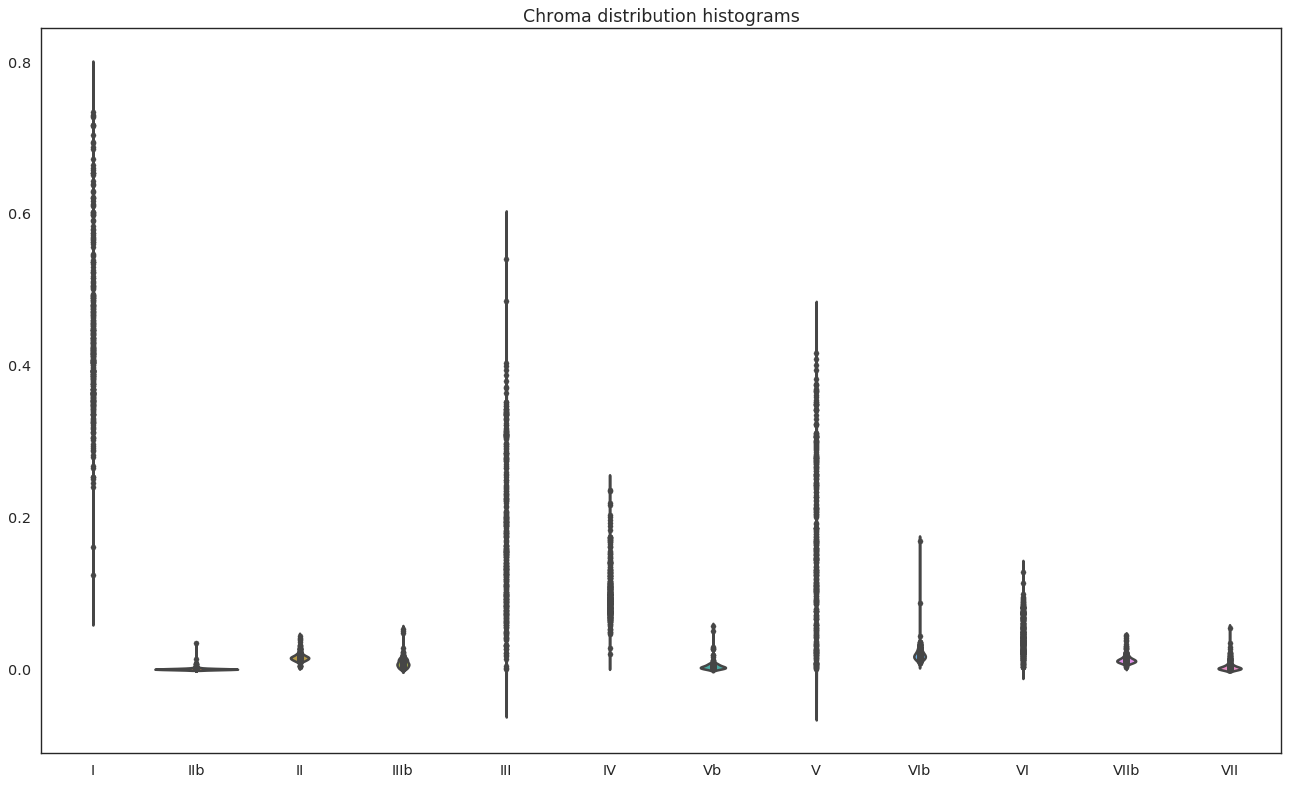

In [6]:
#Plotting statistics of chroma features for major chords
labels = annotateEachChromaSample(majChroma, majSegments)
majTransposed = transposeToARoot(labels, majChroma)
majTransposed = majTransposed[labels != 'N']# get rid of 'No chords'

chromaViolinPlot(majTransposed)

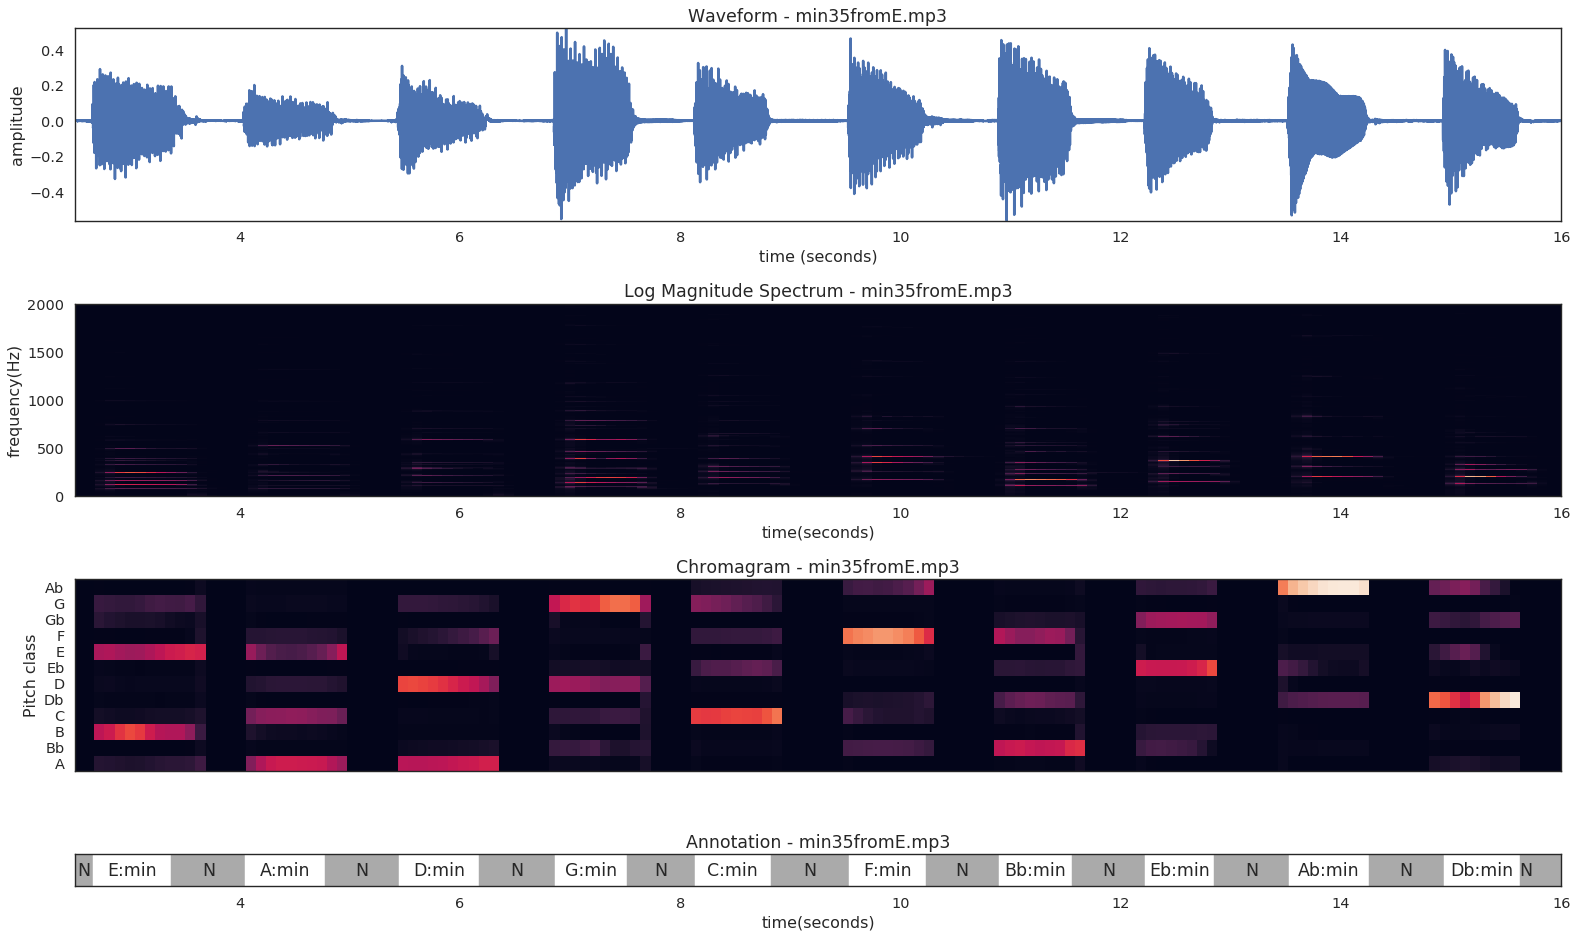

In [7]:
# minor triads
file='min35fromE.mp3'
minWave, minChroma, minSpectra = loadWaveChromaSpectra(filename = soundsDIR + file)
minSegments = loadAnnotatedSegmentsFromLab(soundsDIR + 'min35fromE.lab')
w = plotAnnotatedChroma(minWave, minChroma, minSpectra, minSegments, label=file,startTime=2.5, endTime=16)
ipd.Audio(w, rate=fs)

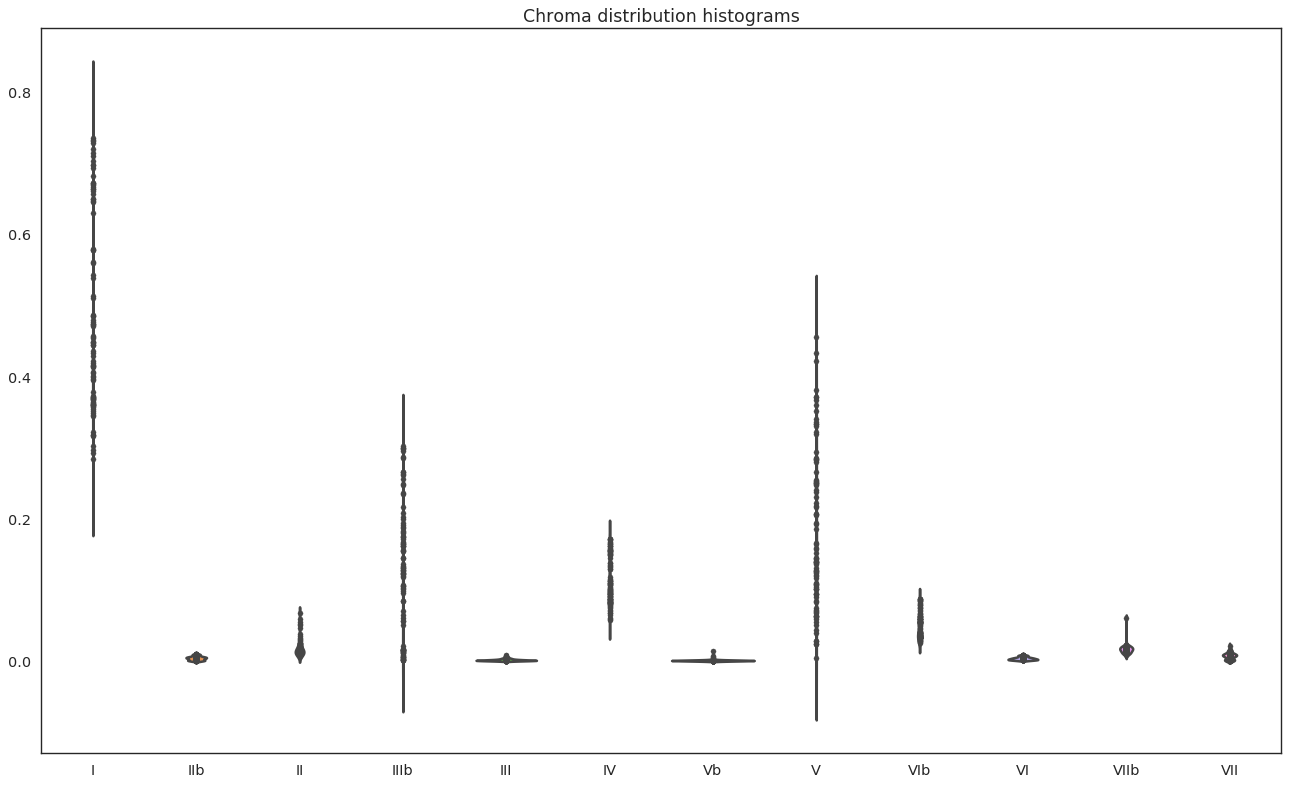

In [8]:
#Plotting statistics of chroma features for minor chords
labels = annotateEachChromaSample(minChroma, minSegments)
minTransposed = transposeToARoot(labels, minChroma)
minTransposed = minTransposed[labels != 'N']# get rid of 'No chords'

chromaViolinPlot(minTransposed)

## 2. Train model for major and minor triads recognition

In [9]:
def mergeSegments(src_labels, hopSize = 4096, fs = 44100) :
    labels = []
    startTimes = []
    durations = []
    if (len(src_labels) > 0):
        step = float(hopSize) / fs
        time = 0
        duration = 0
        previous = src_labels[0]
        for l in src_labels:
            if (previous != l):
                labels.append(previous)
                startTimes.append(time)
                durations.append(duration)
                time += duration
                duration = 0.0
                previous = l
            duration += step
        if (duration > 0):
            labels.append(previous)
            startTimes.append(time)
            durations.append(duration) 
    return AnnotatedSegments(
        np.array(labels, dtype='object'),
        np.array(startTimes, dtype='float'),
        np.array(durations, dtype='float'))

def densitiesForAllRoots(gmm, chromas):
    '''
    Estimate probabilities of the given chroma and gmm
    for all possible roots.
    '''
    p = np.zeros((len(chromas), len(pitchClasses)))
    for basePitch in range(len(pitchClasses)):
        preChromas = preprocessTransposedChromas(chromas)
        p[:, basePitch] = np.exp(gmm.score_samples(preChromas))
        chromas = np.roll(chromas, -1, axis=1)
    return p            

In [10]:
def predictChordSegments(chroma, majGMM, minGMM, threshold = 0.01, hopSize = 4096, fs = 44100):
    '''
    Predicts chord segments
    '''
    allMaj = densitiesForAllRoots(majGMM, chroma)
    allMin = densitiesForAllRoots(minGMM, chroma)
    iMaj = np.argmax(allMaj, axis=1)
    iMin = np.argmax(allMin, axis=1)
    pMaj = np.max(allMaj, axis=1)
    pMin = np.max(allMin, axis=1)
    labels = np.empty(chroma.shape[0], dtype='object')
    for i in range(len(labels)):
        if (pMaj[i] > pMin[i]):
            labels[i] = pitchClasses[iMaj[i]]
        else:
            labels[i] = pitchClasses[iMin[i]] + ':min'
        if (pMaj[i] < threshold and pMin[i] < threshold):
            labels[i] = 'N'
    return mergeSegments(labels, hopSize, fs)

# train the model

majGaussian = GaussianMixture(
                n_components=1,
                covariance_type='full',
                max_iter=200,
                random_state = 8)
majGaussian.fit(majTransposed)

minGaussian = GaussianMixture(
                n_components=1,
                covariance_type='full',
                max_iter=200,
                random_state = 8)
minGaussian.fit(minTransposed)
print('Training is complete')

Training is complete


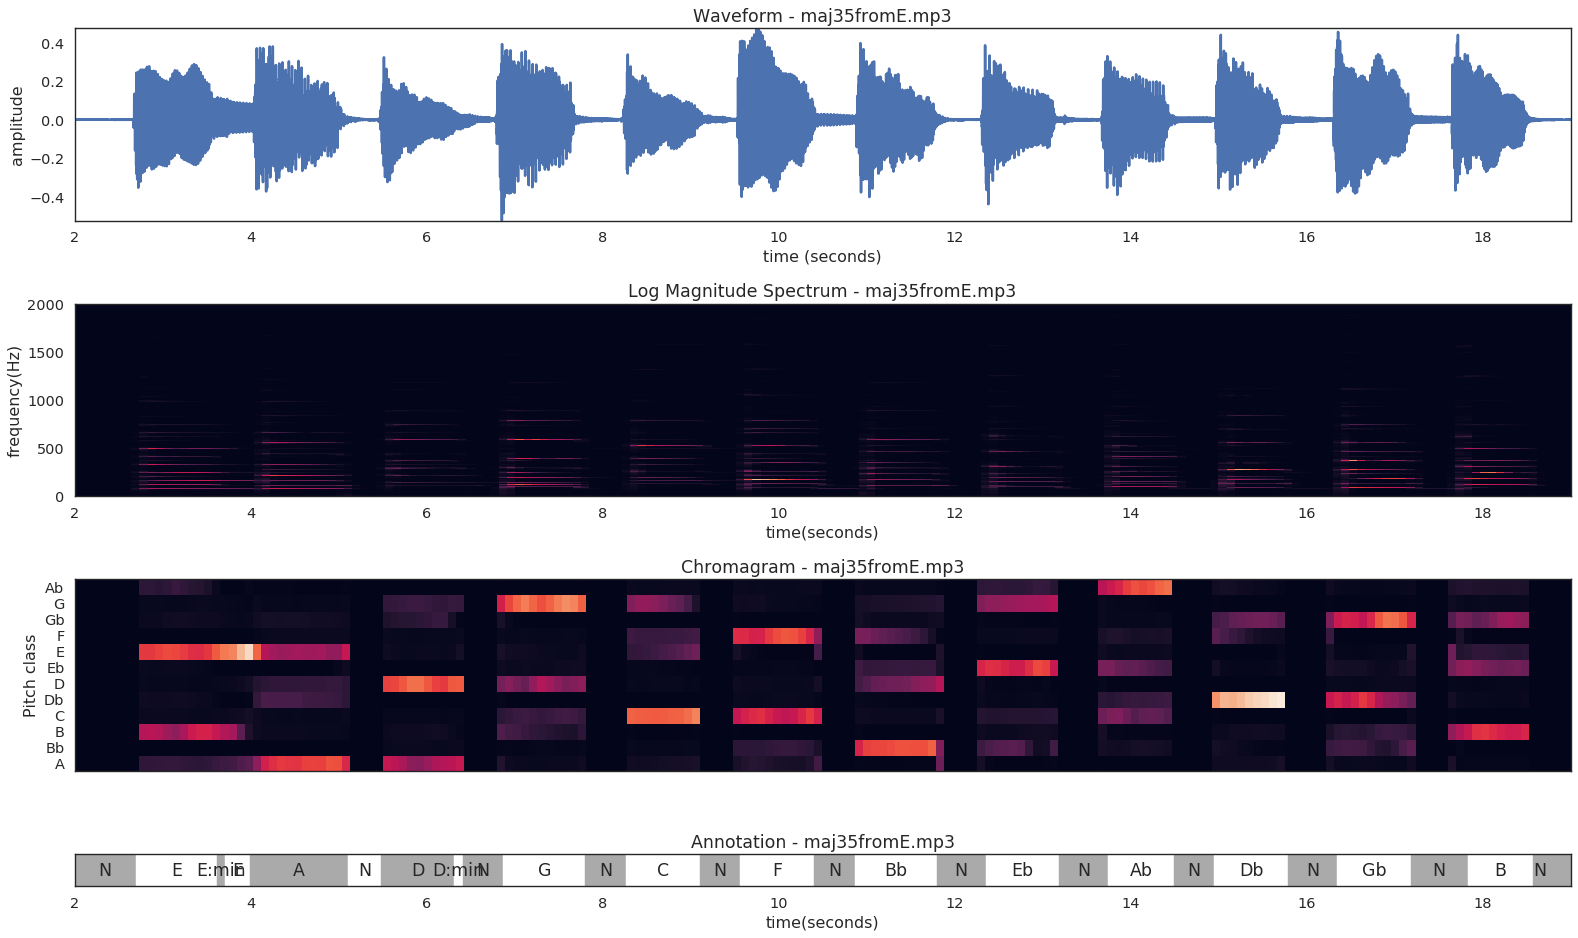

True labels:  ['E' 'A' 'D' 'G' 'C' 'F' 'Bb' 'Eb' 'Ab' 'Db' 'Gb' 'B']


In [11]:
# Prediction on the training set

# Choose metaparameter threshold: 
#  if probability density for both major and minor
#  is less than the threshold, "NO CHORD" is assigned.
threshold = 10**6
start_time=2
end_time=19

#Recording including major chords
predictedSegments = predictChordSegments(majChroma, majGaussian, minGaussian, threshold = threshold)
w = plotAnnotatedChroma(majWave, majChroma, majSpectra, predictedSegments, label='maj35fromE.mp3',startTime=start_time, endTime=end_time)

#Printing true-labels/ground-truth annotations for comparison  
sT = majSegments.startTimes
trueLabels=majSegments.labels[sT<end_time]
trueLabels=trueLabels[trueLabels!= 'N']
print('True labels: ',trueLabels)

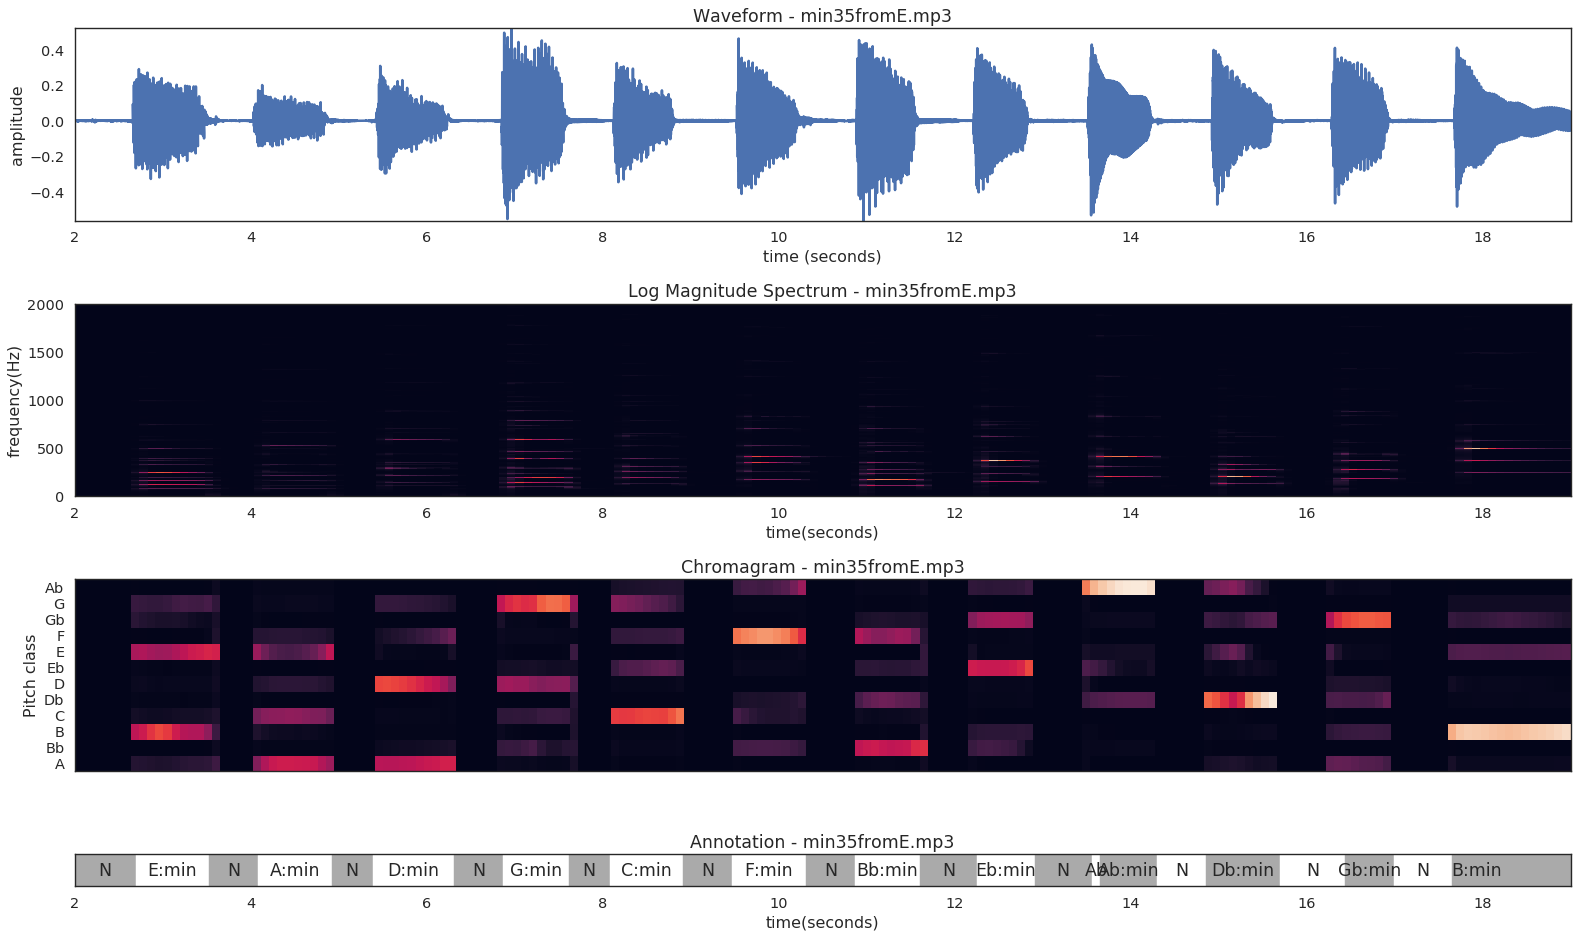

True labels: ['E:min' 'A:min' 'D:min' 'G:min' 'C:min' 'F:min' 'Bb:min' 'Eb:min' 'Ab:min'
 'Db:min' 'Gb:min' 'B:min']


In [12]:
#Recording including minor chords
predictedSegments = predictChordSegments(minChroma, majGaussian, minGaussian, threshold = threshold)
w = plotAnnotatedChroma(minWave, minChroma, minSpectra, predictedSegments, label='min35fromE.mp3',startTime=start_time, endTime=end_time)

#Printing true-labels/ground-truth annotations for comparison  
sT = minSegments.startTimes
trueLabels=minSegments.labels[sT<end_time]
trueLabels=trueLabels[trueLabels!= 'N']
print('True labels:',trueLabels)

In [13]:
# download a sound from freesound, play, predict chord and sonify.
import sys,os
sys.path.append(os.path.join(os.path.dirname('__file__'), 'freesound-python/'))

import freesound
client = freesound.FreesoundClient()
#You are expected to place your token in the line below
#client.set_token("...your token...","token")
client.set_token("312dfda1ffe240d1d97ef06565477b52151a84c7","token")
maxNumFilePerInst=3

# Choose some other string
queryString="chord major guitar"
results = client.text_search(query=queryString,fields="id,name,previews,tags")
cnt=0
files=[]
for sound in results:
    print(sound.name)
    sound.retrieve_preview(".",sound.name)
    files.append(sound.name)
    cnt=cnt+1
    if cnt>=maxNumFilePerInst:
        break

print("Files are copied! check your folder")

F#add11 moment.mp3
D Major.wav
E Major.wav
Files are copied! check your folder


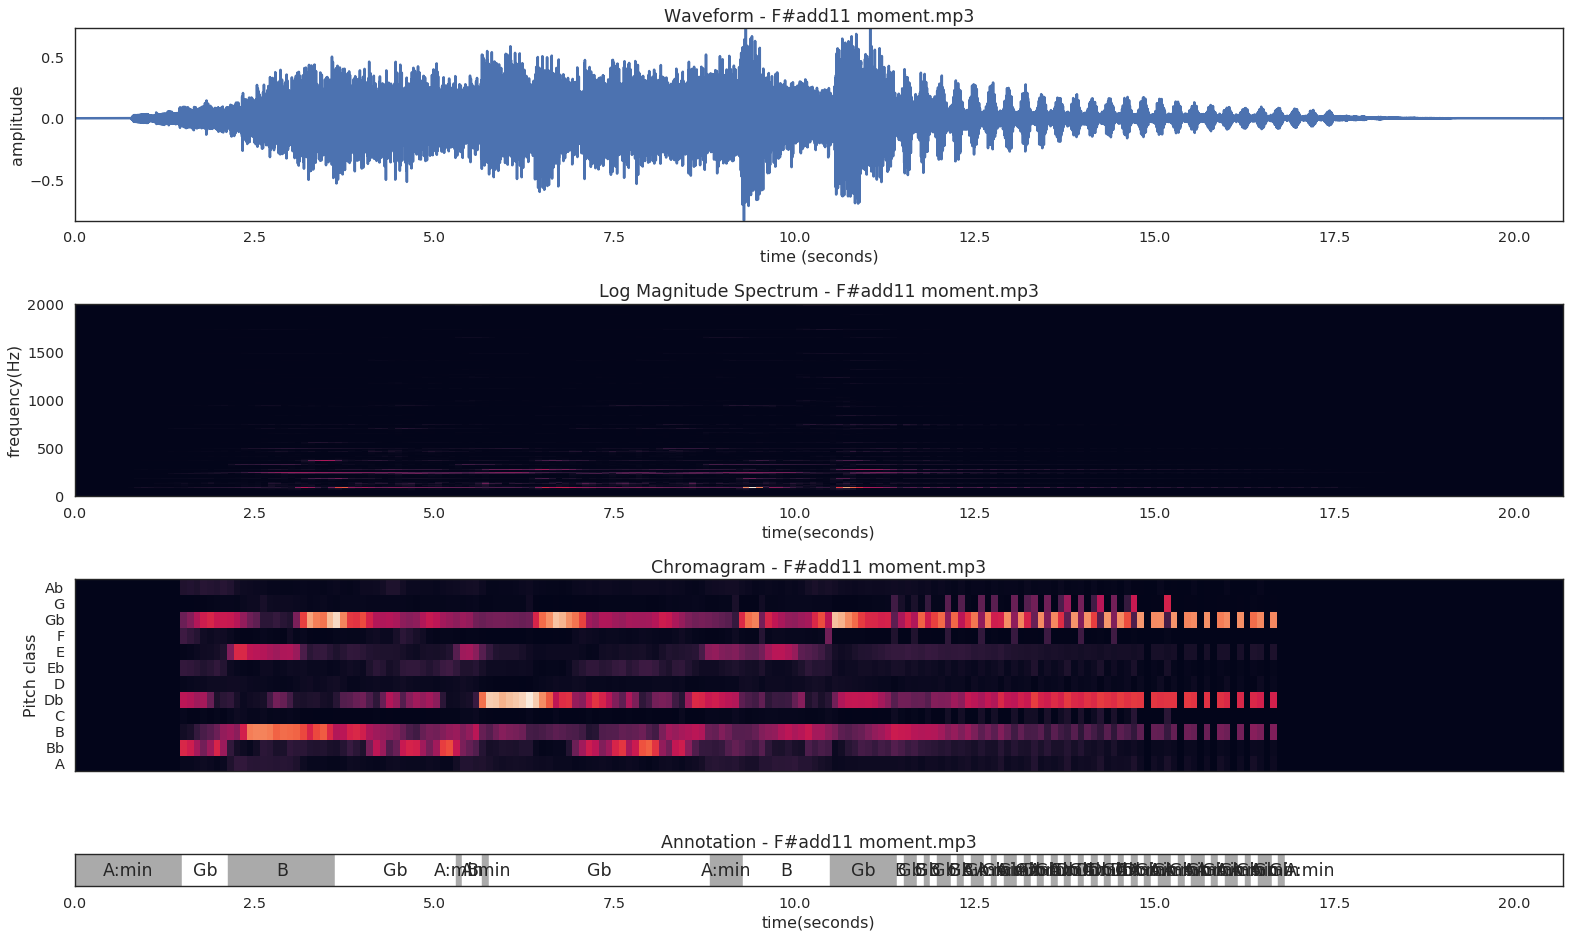

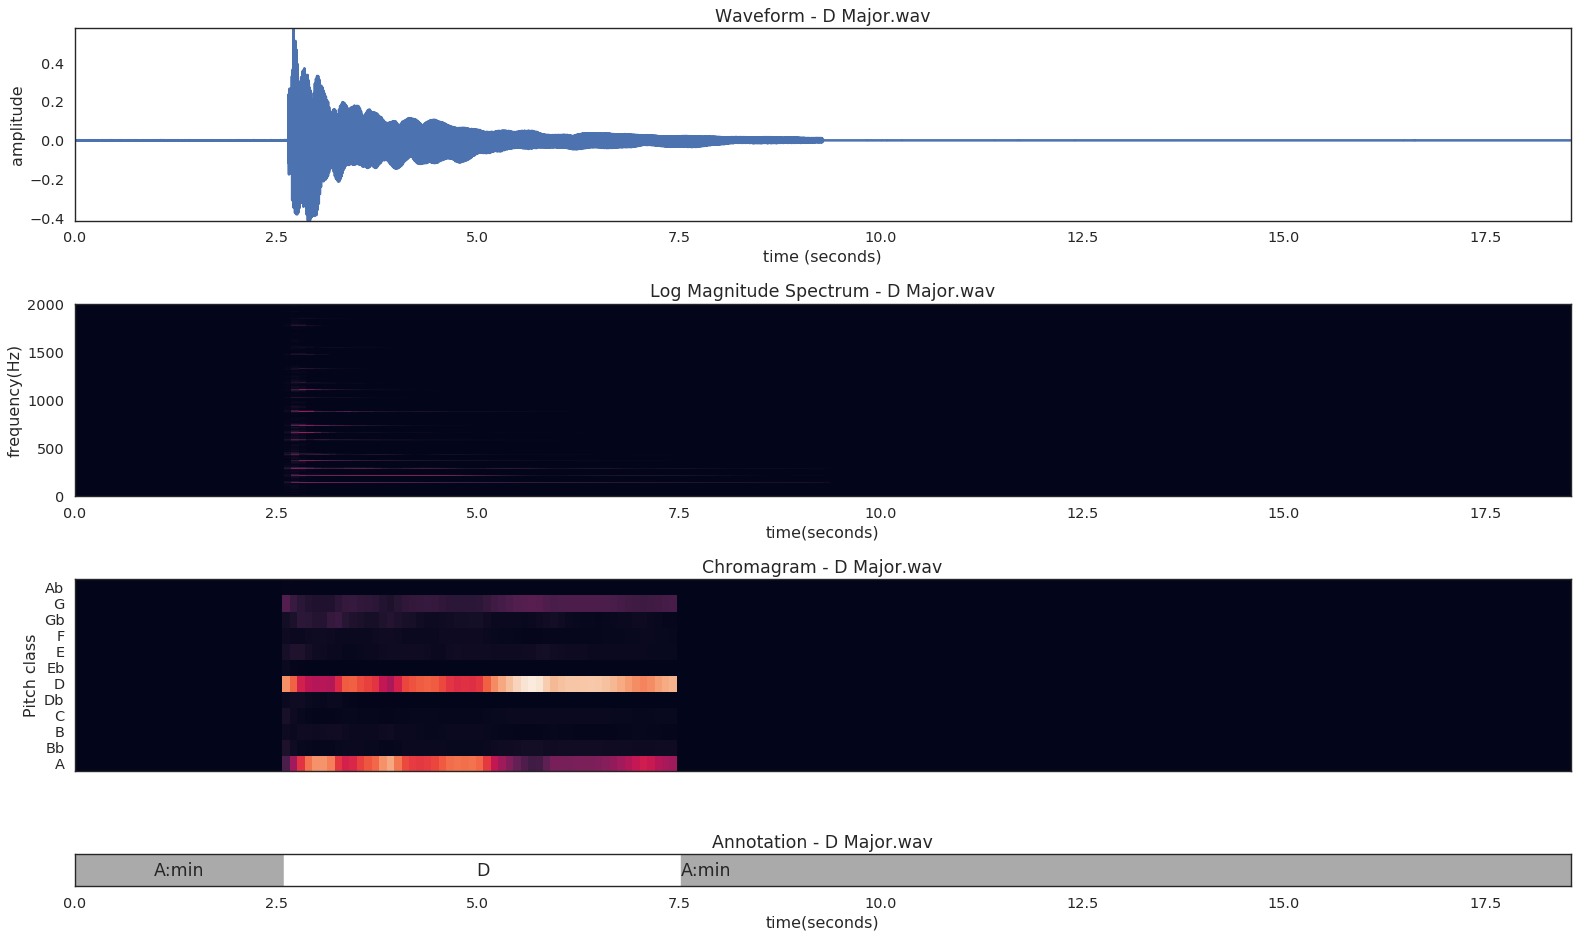

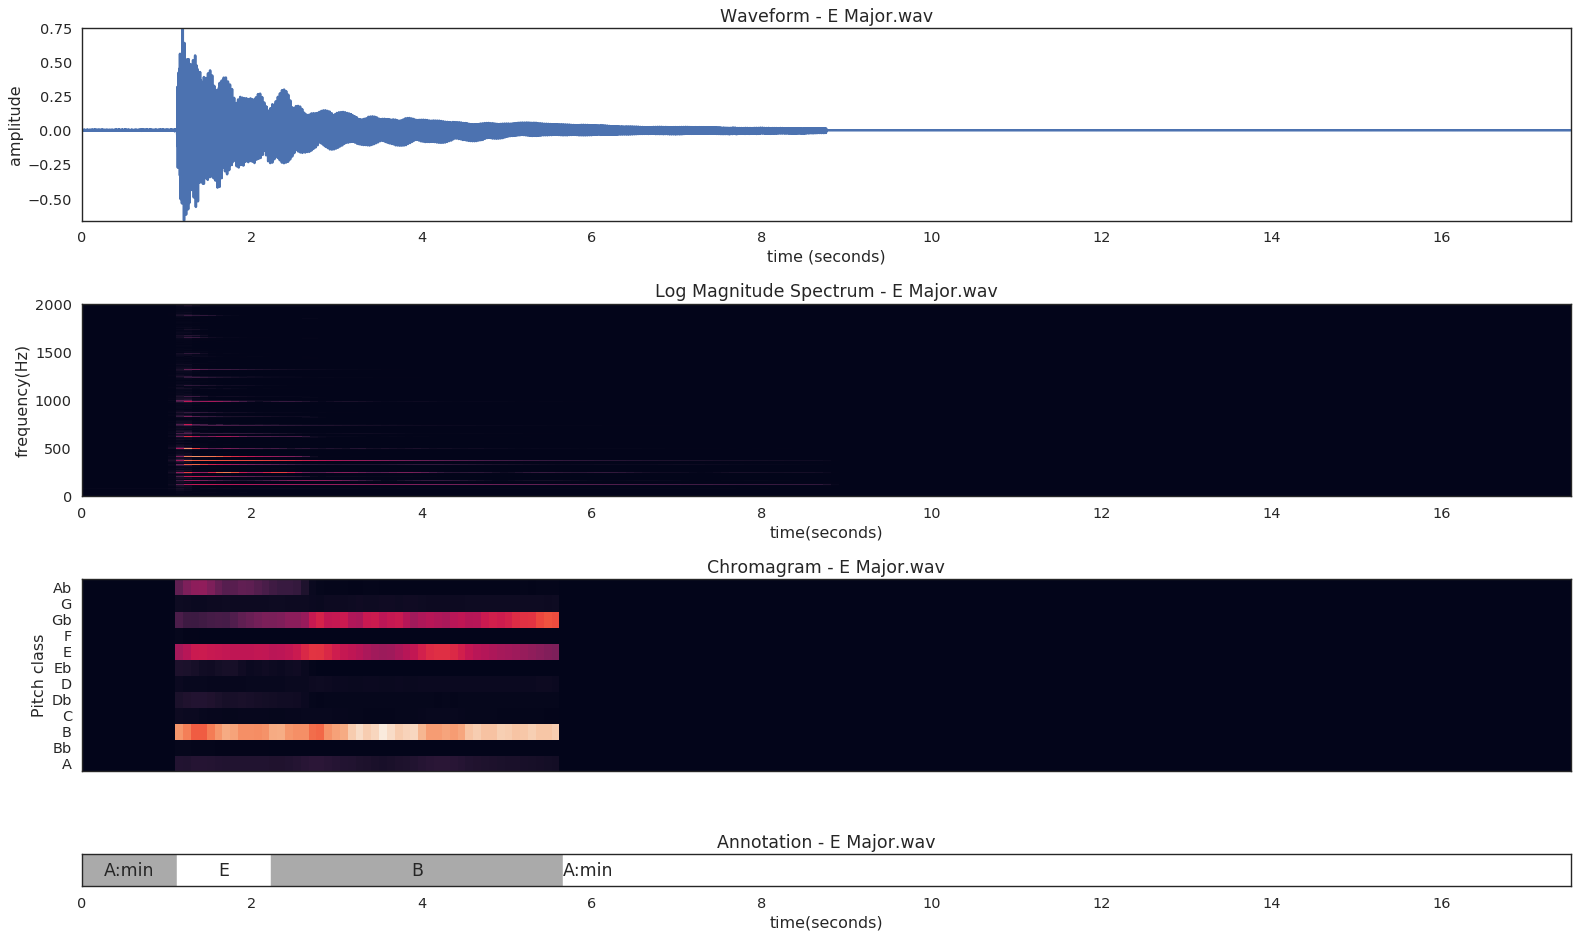

In [14]:
#Running chord estimation for the downloaded files
threshold = 0
for file in files:
    wave, chroma, spectra = loadWaveChromaSpectra(filename = file)
    predictedSegments = predictChordSegments(chroma, majGaussian, minGaussian, threshold = threshold)
    w = plotAnnotatedChroma(wave, chroma, spectra, predictedSegments,label=file)
